In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

from qiskit.circuit import QuantumCircuit, Parameter, ParameterVector
from qiskit.circuit.library import RYGate, CRYGate
from qiskit.visualization import circuit_drawer

from susy_qm import calculate_Hamiltonian

import pennylane as qml
import numpy as np

from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp
from qiskit.transpiler import generate_preset_pass_manager
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from qiskit_ibm_runtime import EstimatorOptions
from qiskit_aer import AerSimulator
from qiskit.quantum_info import Statevector

In [5]:
cutoff = 16
potential = 'DW'

In [10]:
# Calculate Hamiltonian and expected eigenvalues
H = calculate_Hamiltonian(cutoff, potential)
eigenvalues, eigenvectors = np.linalg.eig(H)
min_3_ev = eigenvalues.argsort()[:4]
min_eigenvector = np.asarray(eigenvectors[:, min_3_ev[0]])

num_qubits = int(1 + np.log2(cutoff))

observables = SparsePauliOp.from_operator(H)

In [22]:
reps = 1 
varparams = ParameterVector("θ", (reps + 1) * num_qubits)
#params = np.random.rand(2*num_qubits)

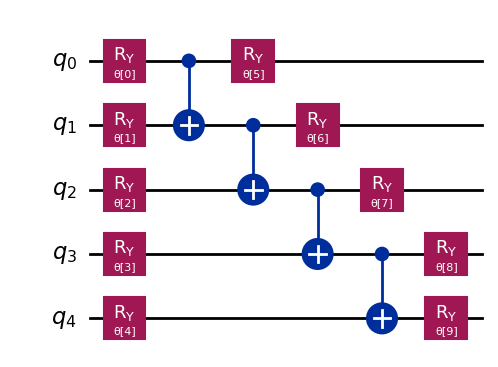

In [23]:
qc = QuantumCircuit(num_qubits)
param_index = 0

for rep in range(reps):
    for i in range(num_qubits):
        qc.ry(varparams[param_index], i)
        param_index += 1
    
    for i in range(num_qubits - 1):
        qc.cx(i, i + 1)

for i in range(num_qubits):
    qc.ry(varparams[param_index], i)
    param_index += 1

qc.draw('mpl')


In [27]:
params = np.random.rand(2*num_qubits)
bound_circuit = qc.assign_parameters({param: val for param, val in zip(varparams, params)}, inplace=False)

In [28]:
state = Statevector.from_instruction(bound_circuit)
expectation = state.expectation_value(observables)
expectation

np.complex128(90.5513975391444+0j)

In [34]:
options = EstimatorOptions()
options.default_shots = 100
backend = AerSimulator()
estimator = Estimator(backend, options=options)

lowest = np.inf
energies = []
for i in range(1000):
    params = np.random.rand(2*num_qubits)*2*np.pi
    job = estimator.run([(qc, observables, params)])
    e = job.result()[0].data.evs.sum()
    energies.append(e)
    if e < lowest:
        lowest = e
        print(i, lowest)

0 7.2956335971270665
63 0.5441979460354638
291 -4.639284951275999


running for shots: 2
circuit eval: 0
circuit eval: 1000
circuit eval: 2000
circuit eval: 3000
circuit eval: 4000
circuit eval: 5000
circuit eval: 6000
circuit eval: 7000
circuit eval: 8000
circuit eval: 9000
running for shots: 32
circuit eval: 0
circuit eval: 1000
circuit eval: 2000
circuit eval: 3000
circuit eval: 4000
circuit eval: 5000
circuit eval: 6000
circuit eval: 7000
circuit eval: 8000
circuit eval: 9000
running for shots: 1024
circuit eval: 0
circuit eval: 1000
circuit eval: 2000
circuit eval: 3000
circuit eval: 4000
circuit eval: 5000
circuit eval: 6000
circuit eval: 7000
circuit eval: 8000
circuit eval: 9000
running for shots: 10000
circuit eval: 0
circuit eval: 1000
circuit eval: 2000
circuit eval: 3000
circuit eval: 4000
circuit eval: 5000
circuit eval: 6000
circuit eval: 7000
circuit eval: 8000
circuit eval: 9000


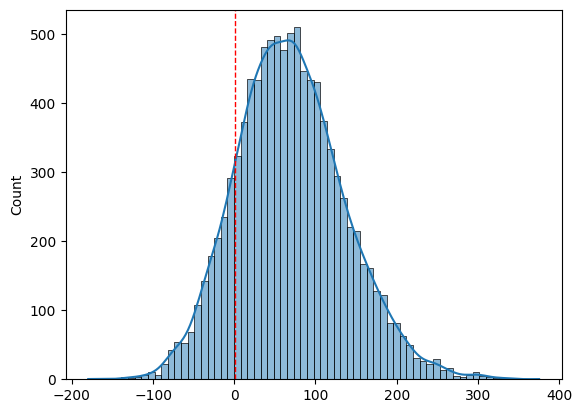

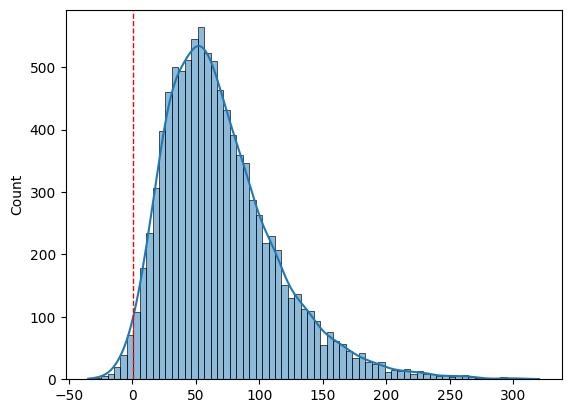

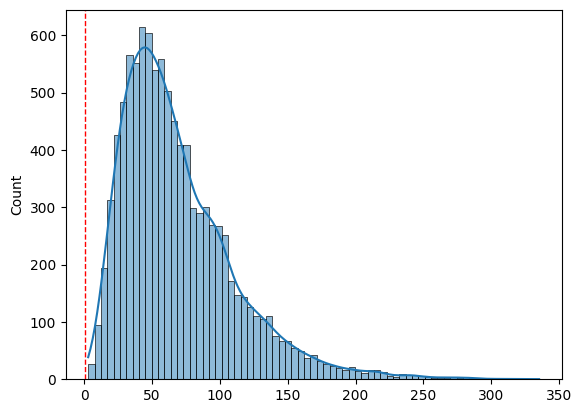

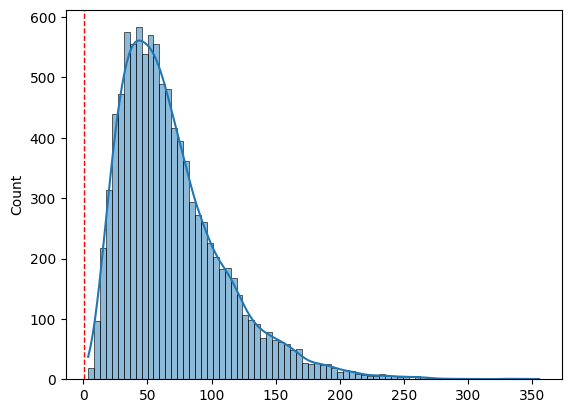

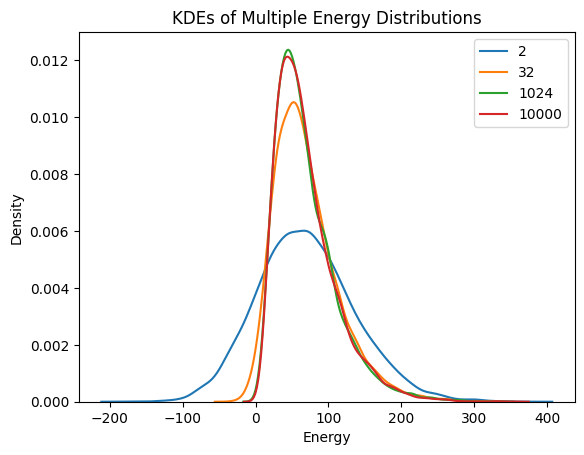

In [35]:
backend = AerSimulator()

#shots_list = [2, 4, 8, 32, 128, 512, 1024, 2048, 4096, 10000]
shots_list = [2, 32, 1024, 10000]
all_energies = []
for shots in shots_list:

    print(f"running for shots: {shots}")

    options = EstimatorOptions()
    options.default_shots = shots
    estimator = Estimator(backend, options=options)

    lowest = np.inf
    energies = []
    for i in range(10000):

        if i % 1000 == 0:
            print(f"circuit eval: {i}")

        params = np.random.rand(2*num_qubits)*2*np.pi
        job = estimator.run([(qc, observables, params)])
        e = job.result()[0].data.evs.sum()
        energies.append(e)

    all_energies.append(energies)

    plt.figure()
    sns.histplot(energies, kde=True)
    plt.axvline(x=0.89159936, color='red', linestyle='--', linewidth=1.0)
    plt.savefig(r"C:\Users\Johnk\Documents\PhD\Quantum Computing Code\Quantum-Computing\SUSY\SUSY QM\Qiskit\EnergyDistributions\Histograms\Histo_{}.png".format(str(shots)))

plt.figure()
for i, e in enumerate(all_energies):

    sns.kdeplot(e, label=f"{shots_list[i]}")

plt.legend()
plt.xlabel("Energy")
plt.ylabel("Density")
plt.title("KDEs of Multiple Energy Distributions")
plt.savefig(r"C:\Users\Johnk\Documents\PhD\Quantum Computing Code\Quantum-Computing\SUSY\SUSY QM\Qiskit\EnergyDistributions\Histograms\probs.png")


In [22]:
np.mean(e)

np.float64(69.4904399665205)

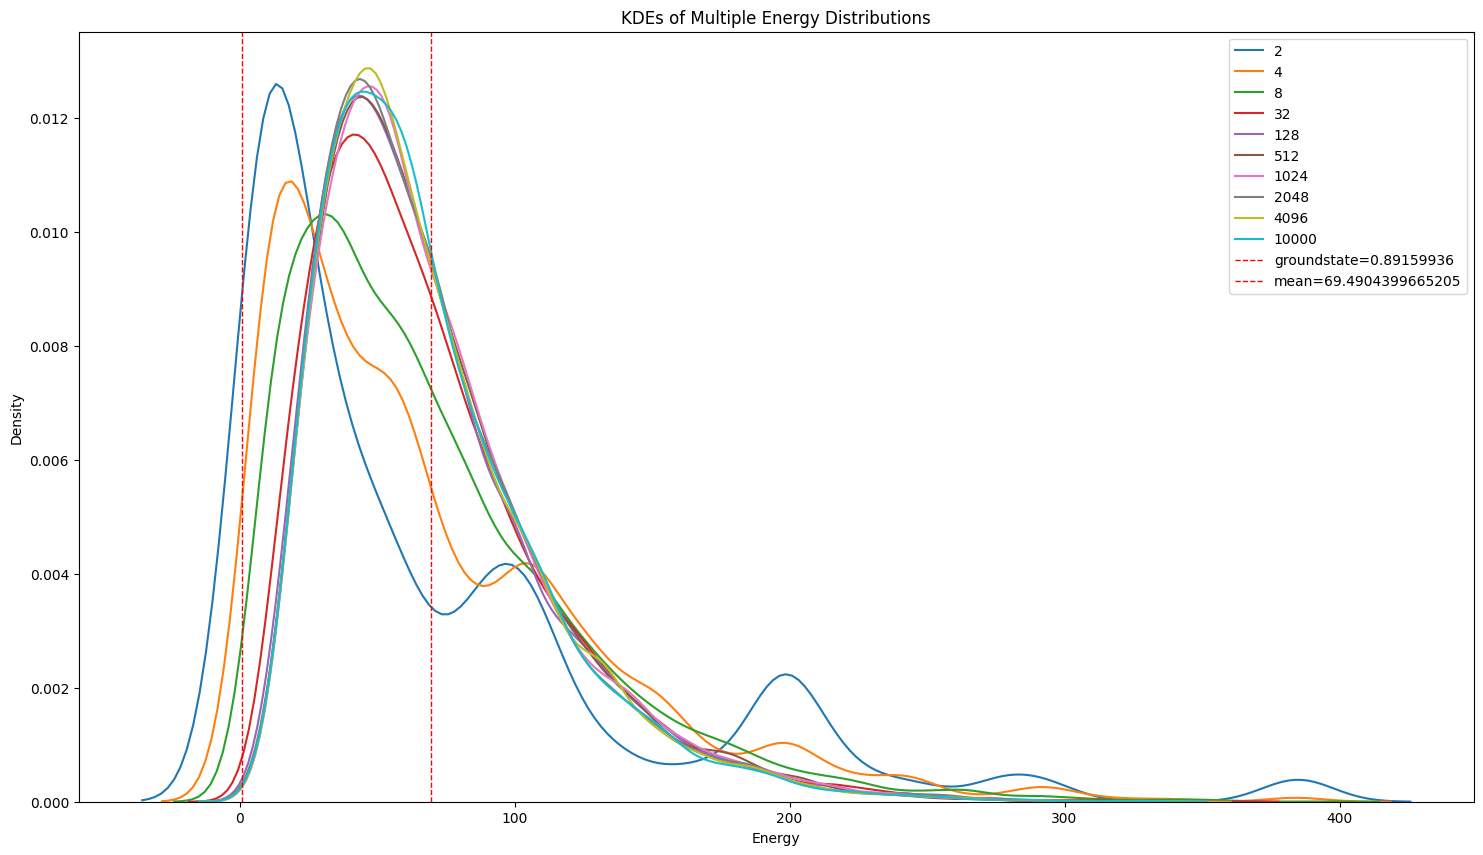

In [25]:
plt.figure(figsize=(18,10))
for i, e in enumerate(all_energies):

    sns.kdeplot(e, label=f"{shots_list[i]}")

mean = np.mean(e)
plt.axvline(x=0.89159936, color='red', linestyle='--', linewidth=1.0, label='groundstate=0.89159936')
plt.axvline(x=mean, color='red', linestyle='--', linewidth=1.0, label=f'mean={mean}')
plt.legend()
plt.xlabel("Energy")
plt.ylabel("Density")
plt.title("KDEs of Multiple Energy Distributions")
plt.show()

running for shots: 2
circuit eval: 0
circuit eval: 1000
circuit eval: 2000
circuit eval: 3000
circuit eval: 4000
circuit eval: 5000
circuit eval: 6000
circuit eval: 7000
circuit eval: 8000
circuit eval: 9000
running for shots: 4
circuit eval: 0
circuit eval: 1000
circuit eval: 2000
circuit eval: 3000
circuit eval: 4000
circuit eval: 5000
circuit eval: 6000
circuit eval: 7000
circuit eval: 8000
circuit eval: 9000
running for shots: 8
circuit eval: 0
circuit eval: 1000
circuit eval: 2000
circuit eval: 3000
circuit eval: 4000
circuit eval: 5000
circuit eval: 6000
circuit eval: 7000
circuit eval: 8000
circuit eval: 9000
running for shots: 32
circuit eval: 0
circuit eval: 1000
circuit eval: 2000
circuit eval: 3000
circuit eval: 4000
circuit eval: 5000
circuit eval: 6000
circuit eval: 7000
circuit eval: 8000
circuit eval: 9000
running for shots: 128
circuit eval: 0
circuit eval: 1000
circuit eval: 2000
circuit eval: 3000
circuit eval: 4000
circuit eval: 5000
circuit eval: 6000
circuit eval: 

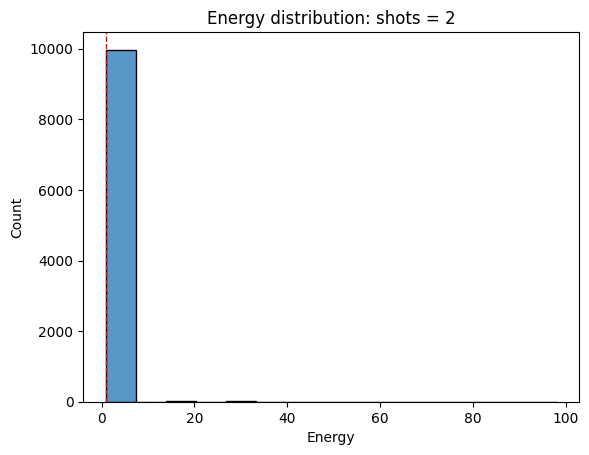

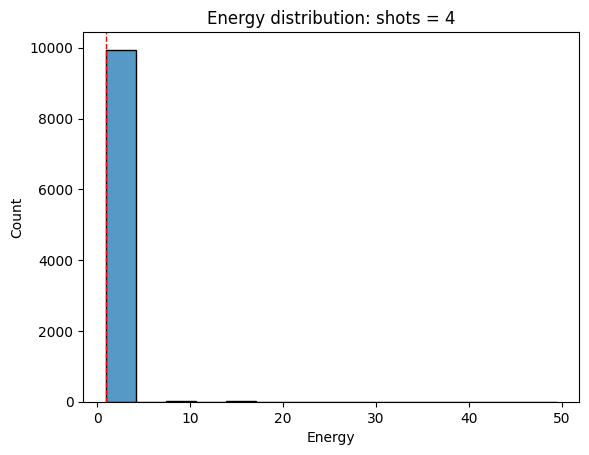

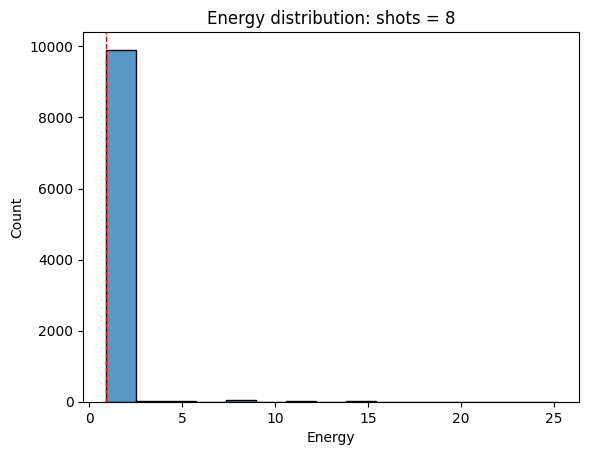

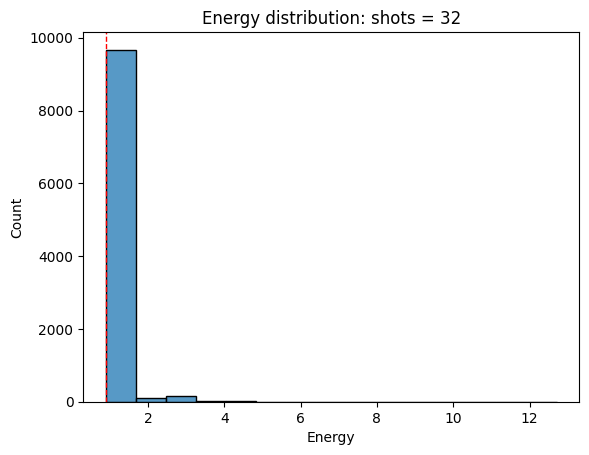

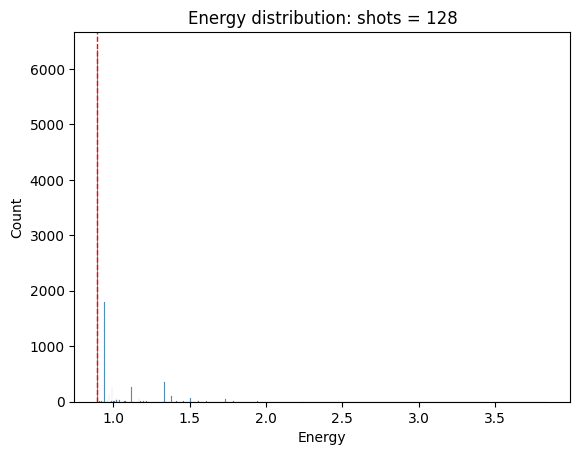

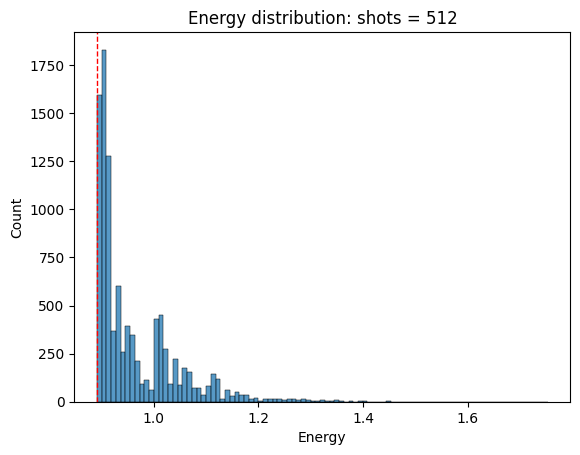

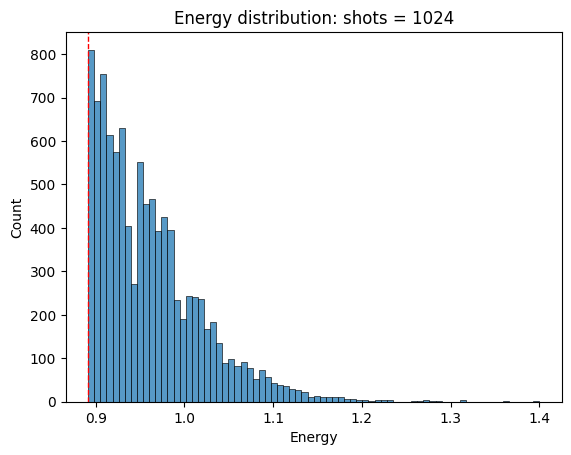

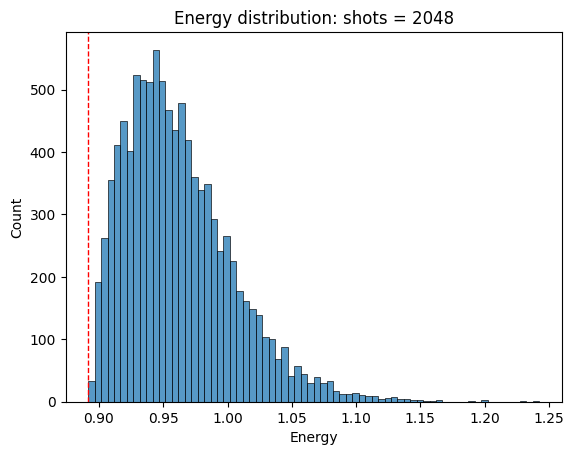

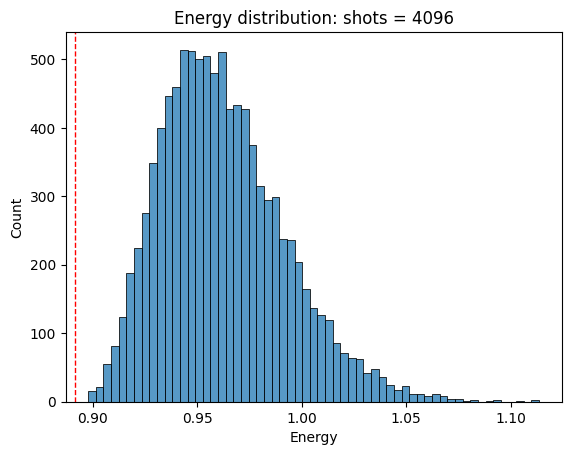

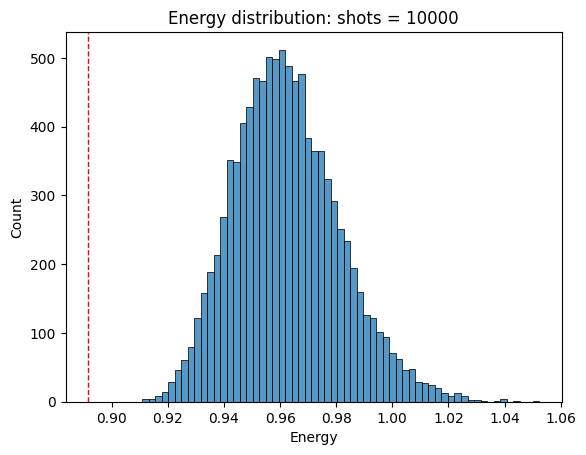

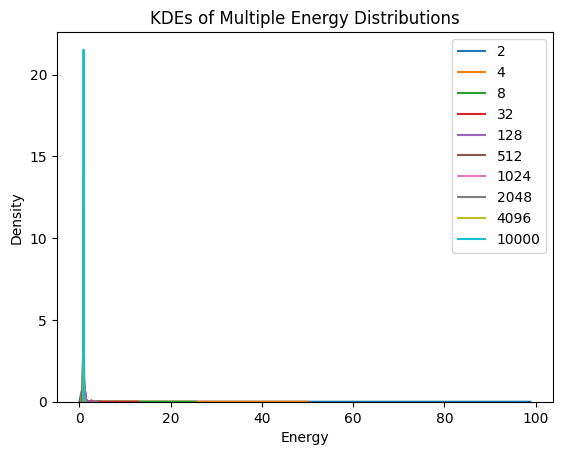

In [47]:
shots_list = [2, 4, 8, 32, 128, 512, 1024, 2048, 4096, 10000]
all_energies = []


params = [
            1.6030557743624225,
            4.708882032084252,
            1.5927116455932047,
            0.7453696011323698,
            2.7112379205665893,
            4.721932631793341,
            1.5783945888241828,
            1.4632540703530639,
            4.043882986825778,
            2.1520442158563426
        ]

for shots in shots_list:

    print(f"running for shots: {shots}")

    dev = qml.device("default.qubit", wires=num_qubits, shots=shots, seed=1088653)
    @qml.qnode(dev)
    def circuit(params):
        
        param_index=0
        for i in range(num_qubits):
            qml.RY(params[param_index], wires=i)
            param_index += 1

        for j in reversed(range(1, num_qubits)):
            qml.CNOT(wires=[j, j-1])

        for k in range(num_qubits):
            qml.RY(params[param_index], wires=k)
            param_index += 1
            
        return qml.expval(qml.Hermitian(H, wires=range(num_qubits)))
    
    lowest = np.inf
    energies = []
    for i in range(10000):

        if i % 1000 == 0:
            print(f"circuit eval: {i}")

        e = circuit(params)
        energies.append(e)

    all_energies.append(energies)

    plt.figure()
    sns.histplot(energies, kde=False)
    plt.xlabel("Energy")
    plt.title(f"Energy distribution: shots = {shots}")
    plt.axvline(x=0.89159936, color='red', linestyle='--', linewidth=1.0)
    plt.savefig(r"C:\Users\Johnk\Documents\PhD\Quantum Computing Code\Quantum-Computing\SUSY\SUSY QM\PennyLane\EnergyDistributions\HistogramsDEParams\Histo_{}.png".format(str(shots)))

plt.figure()
for i, e in enumerate(all_energies):

    sns.kdeplot(e, label=f"{shots_list[i]}")

plt.legend()
plt.xlabel("Energy")
plt.ylabel("Density")
plt.title("KDEs of Multiple Energy Distributions")
plt.savefig(r"C:\Users\Johnk\Documents\PhD\Quantum Computing Code\Quantum-Computing\SUSY\SUSY QM\PennyLane\EnergyDistributions\HistogramsDEParams\probs.png")


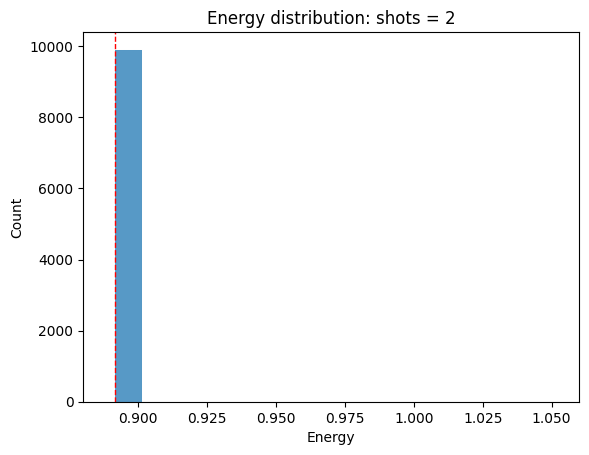

In [56]:
plt.figure()
sns.histplot(all_energies[0], kde=False, bins=10000)  # increase bins for resolution
plt.xlabel("Energy")
plt.title(f"Energy distribution: shots = {2}")
plt.axvline(x=0.89159936, color='red', linestyle='--', linewidth=1.0)
plt.xlim(0.88, 1.06)  # <- manually set range around the ground state
plt.show()


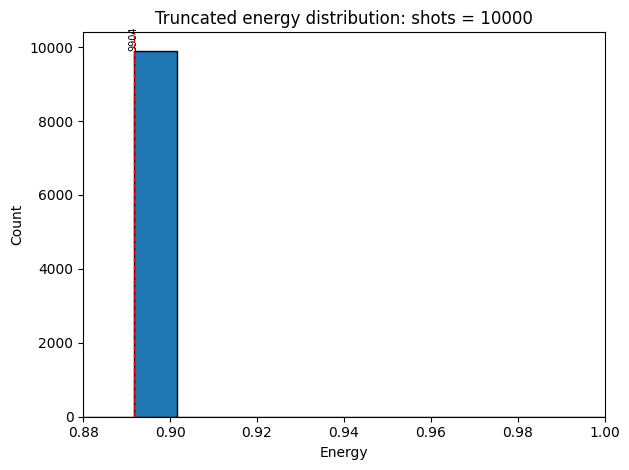

In [55]:

# Your histogram data
data = all_energies[0]
bin_range = (0.88, 1.0)

# Truncate data
data = [e for e in data if bin_range[0] <= e <= bin_range[1]]

# Create histogram and get counts
plt.figure()
counts, bins, patches = plt.hist(data, bins=100, edgecolor='black')

# Annotate each bar
for count, bin_left, patch in zip(counts, bins, patches):
    if count > 0:
        plt.text(bin_left, count + 2, str(int(count)), ha='center', va='bottom', fontsize=7, rotation=90)

plt.xlabel("Energy")
plt.ylabel("Count")
plt.title(f"Truncated energy distribution: shots = {shots}")
plt.axvline(x=0.89159936, color='red', linestyle='--', linewidth=1.0)
plt.xlim(*bin_range)
plt.tight_layout()
plt.show()


In [42]:
dev = qml.device("default.qubit", wires=num_qubits, shots=None, seed=29196039)
@qml.qnode(dev)
def circuit(params):
    
    param_index=0
    for i in range(num_qubits):
        qml.RY(params[param_index], wires=i)
        param_index += 1

    for j in reversed(range(1, num_qubits)):
        qml.CNOT(wires=[j, j-1])

    for k in range(num_qubits):
        qml.RY(params[param_index], wires=k)
        param_index += 1
        
    return qml.state()

In [45]:
state = circuit(params)

In [46]:
overlap = np.vdot(min_eigenvector, state)  # ⟨eigenvector|ψ⟩
fidelity = np.abs(overlap)**2

print(f"Overlap: {overlap}")
print(f"Fidelity: {fidelity}")

Overlap: (0.9981748612242286+0j)
Fidelity: 0.996353053580008
